In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumReturn):
    """
    cagr, dd, mdd
    투자 성과 지표 + 시각화
    """
    # cagr
    cagr = cumReturn.iloc[-1] ** (252/len(cumReturn))
    # mdd
    dd = (cumReturn.cummax() - cumReturn) / cumReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"최종수익률: {cumReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    
    cumReturn = pd.DataFrame(cumReturn)
    cumReturn.columns = ['cumReturn']
    cumReturn['year'] = cumReturn.index.year
    cumReturn['month'] = cumReturn.index.month

    # 월별 데이터, 연별 데이터
    monthData = cumReturn.drop_duplicates(['year', 'month'], keep="last").copy()
    yearData = cumReturn.drop_duplicates('year', keep="last").copy()

    # 월간수익률
    monthData['monthReturn'] = ((monthData['cumReturn'] / monthData['cumReturn'].shift(1).fillna(1))-1)*100
    
    # 연간수익률
    yearData['yearReturn'] = (yearData['cumReturn'] / yearData['cumReturn'].shift(1) -1)*100
    yearData.iloc[0, -1] = (yearData.iloc[0, 0] - 1) * 100 # 첫해 연말 수익률
    yearData.iloc[-1, -2] = 12 # 이번달 월을 강제로 12로 설정.. 보기 편하도록
    
    # 수익곡선, 낙폭 시각화
    f,(ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(20, 10))
    cumReturn['cumReturn'].plot(ax=ax1)
    (-1*dd).plot(ax=ax2)
    ax1.set_title("Cumulative Return & Draw Down")

    # 연간, 월간 수익률 시각화
    monthPivot = monthData.pivot('year', 'month', 'monthReturn') # 월간수익률 피봇테이블
    yearPivot = yearData.pivot('year', 'month', 'yearReturn') # 연간수익률 피봇테이블

    f,(ax1,ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [1, 5]}, figsize=(20, 10)) # 두 그래프 비율 1:5 설정
    g1 = sns.heatmap(yearPivot, ax=ax1,annot=True, fmt='.2f',linewidths=.3, cmap="RdYlGn", center=0, cbar=False) # 연간수익률 히트맵
    g2 = sns.heatmap(monthPivot,ax=ax2, annot=True, fmt='.2f',linewidths=.1, cmap="RdYlGn", center=0, cbar=False) # 월간수익률 히트맵
    ax1.set_title("Annual Return")
    ax2.set_title("Monthly Return")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평모스 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평모스 리턴
    return weight, avgMomentumScore

### 실제 주식 매매 단위와 거래 수수료 반영

In [2]:
# 데이터 로드
stock = getCloseData("069500", "2002") # 코스피200 ETF
bond = getCloseData("152380", "2002") # kodex 국고채 10년물 etf

closeDataSet = pd.concat([stock, bond], axis=1)
closeDataSet.columns = ['stock', 'bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,stock,bond
Date,,
2012-01-20,21744,49960.0
2012-01-25,21820,49960.0
2012-01-26,21841,49930.0
2012-01-27,21875,50000.0
2012-01-30,21628,50130.0
...,...,...
2022-08-03,32420,64955.0
2022-08-04,32585,64910.0
2022-08-05,32800,65020.0


In [3]:
# 리밸런싱 날짜
rebalancingDate = getRebalancingDate(closeDataSet)

# 리밸런싱 비율, 동일비중으로 가정
portfolioWeight = [0.5, 0.5]
weightDf = pd.DataFrame([portfolioWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns) 
weightDf

,stock,bond
Date,,
2012-01-31,0.5,0.5
2012-02-29,0.5,0.5
2012-03-30,0.5,0.5
2012-04-30,0.5,0.5
2012-05-31,0.5,0.5
...,...,...
2022-04-29,0.5,0.5
2022-05-31,0.5,0.5
2022-06-30,0.5,0.5


In [17]:
totalAsset = 10000000 # 초기 자본금, 1000만원 가정
prevQuantity = 0 # 초기 자산 보유량

portfolio = pd.DataFrame() # 전체 자산흐름을 담을 데이터프레임
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일


for end in rebalancingDate[1:]:
    weight = weightDf.loc[start] # 당기 리밸런싱 비율
    
    capacity = totalAsset * weight # 리밸런싱 비율에 따른 자산별 가용액,
    
    priceData = closeDataSet.loc[start: end] # 당기 가격 데이터
    priceOnRebalDay = priceData.iloc[0] # 리밸런싱 당일 가격
       
    quantity = capacity // priceOnRebalDay # 이번달 capacity에 따라 실제 보유 해야 할 자산 수
    
    diffQuantity = quantity - prevQuantity # 실제 매매해야하는 수량, 양수-> 매수, 음수 -> 매도
    
    fee = abs(diffQuantity) *  priceOnRebalDay * 0.0015 # 수수료, 0.15% => 0.0015
    
    leftCash = (capacity - quantity * priceOnRebalDay - fee).sum()# 잔여 현금

    
    assetFlow = quantity * priceData # 수량*가격 = 각 자산 흐름   
    valueOnLastDay = assetFlow.iloc[-1].sum() # 월말 평가액
    
    assetFlow['leftCash'] = round(leftCash, 2)
    portfolio = pd.concat([portfolio, assetFlow]) # 데이터프레임에 추가
    
    # 슬리피지를 고려하고 싶다면 여기에 적당한 패널티를 부여할 것
    totalAsset = (valueOnLastDay + leftCash) # (월말 평가액 + 잔여 현금) totalAsset 업데이트,,
    prevQuantity = quantity # 이전 자산 보유량 업데이트
    start = end # 리밸런싱 날짜 업데이트
    
portfolio

,stock,bond,leftCash
Date,,,
2012-01-31,4979376.0,4967820.0,37883.21
2012-02-01,4985559.0,4972770.0,37883.21
2012-02-02,5041664.0,4967820.0,37883.21
2012-02-03,5016016.0,4968810.0,37883.21
2012-02-06,5023344.0,4961880.0,37883.21
...,...,...,...
2022-08-03,7099980.0,7080095.0,74729.44
2022-08-04,7136115.0,7075190.0,74729.44
2022-08-05,7183200.0,7087180.0,74729.44


In [18]:
# 매달 마지막 영업일엔 리밸런싱이 들어간 row만 남긴다.
portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]
portfolio

,stock,bond,leftCash
Date,,,
2012-01-31,4979376.0,4967820.0,37883.21
2012-02-01,4985559.0,4972770.0,37883.21
2012-02-02,5041664.0,4967820.0,37883.21
2012-02-03,5016016.0,4968810.0,37883.21
2012-02-06,5023344.0,4961880.0,37883.21
...,...,...,...
2022-08-03,7099980.0,7080095.0,74729.44
2022-08-04,7136115.0,7075190.0,74729.44
2022-08-05,7183200.0,7087180.0,74729.44


In [19]:
# 포트폴리오 자산흐름
portfolioAssetFlow = portfolio.sum(axis=1)
portfolioAssetFlow

Date
2012-01-31     9985079.21
2012-02-01     9996212.21
2012-02-02    10047367.21
2012-02-03    10022709.21
2012-02-06    10023107.21
                 ...     
2022-08-03    14254804.44
2022-08-04    14286034.44
2022-08-05    14345109.44
2022-08-08    14303629.44
2022-08-09    14288814.44
Length: 2593, dtype: float64

In [7]:
# 누적 수익률
cumReturn = portfolioAssetFlow / portfolioAssetFlow.iloc[0]
cumReturn

Date
2012-01-31    1.000000
2012-02-01    1.001115
2012-02-02    1.006238
2012-02-03    1.003769
2012-02-06    1.003808
                ...   
2022-08-03    1.427611
2022-08-04    1.430738
2022-08-05    1.436655
2022-08-08    1.432500
2022-08-09    1.431017
Length: 2593, dtype: float64

최종수익률: 1.431016633868045
cagr: 1.0354432137292546
mdd: 20.712978399371497


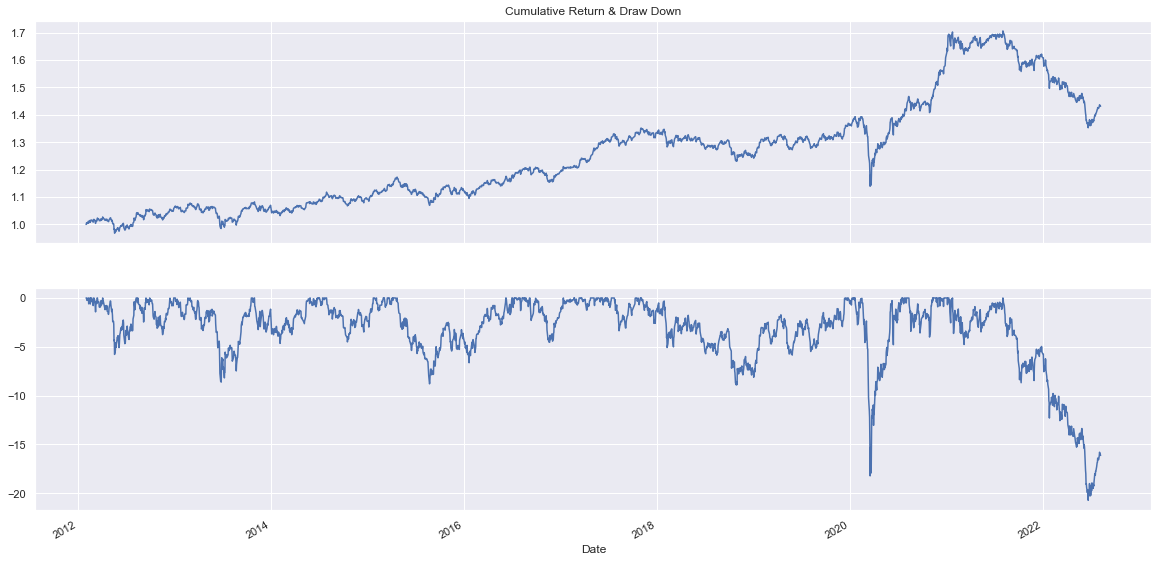

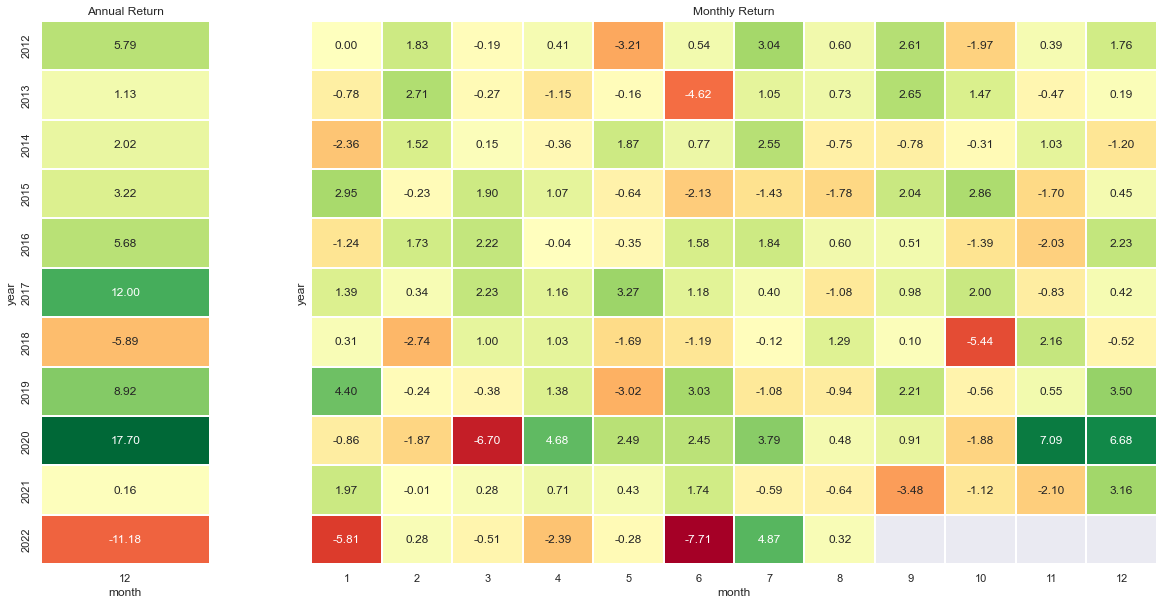

In [20]:
# 수수료 고려
_,_,_ = getEvaluation(cumReturn)

최종수익률: 1.4378933511732022
cagr: 1.035925739551786
mdd: 20.75428106156669


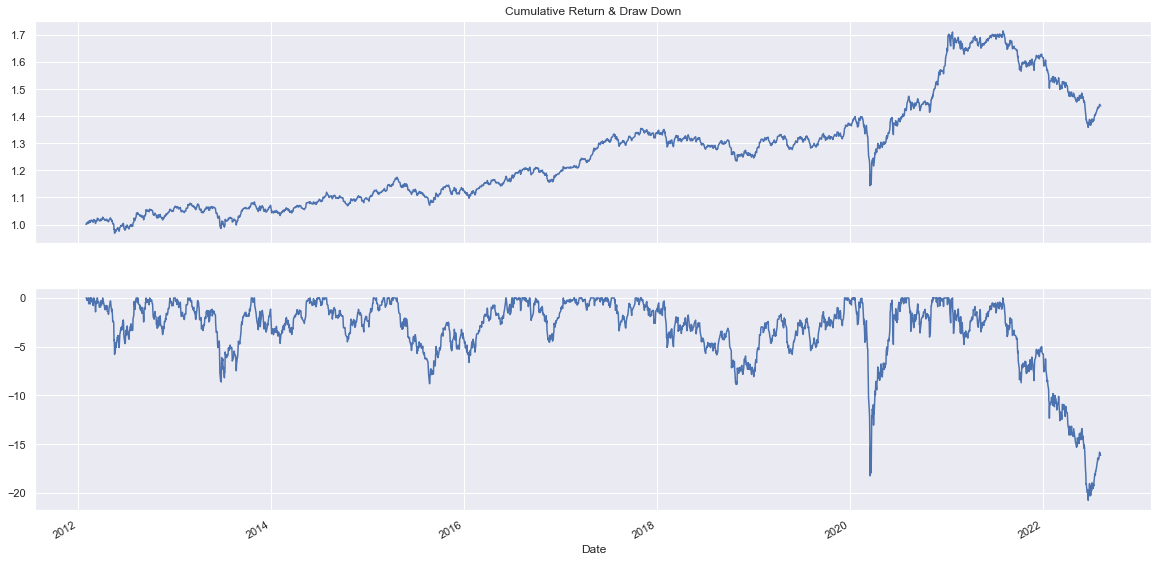

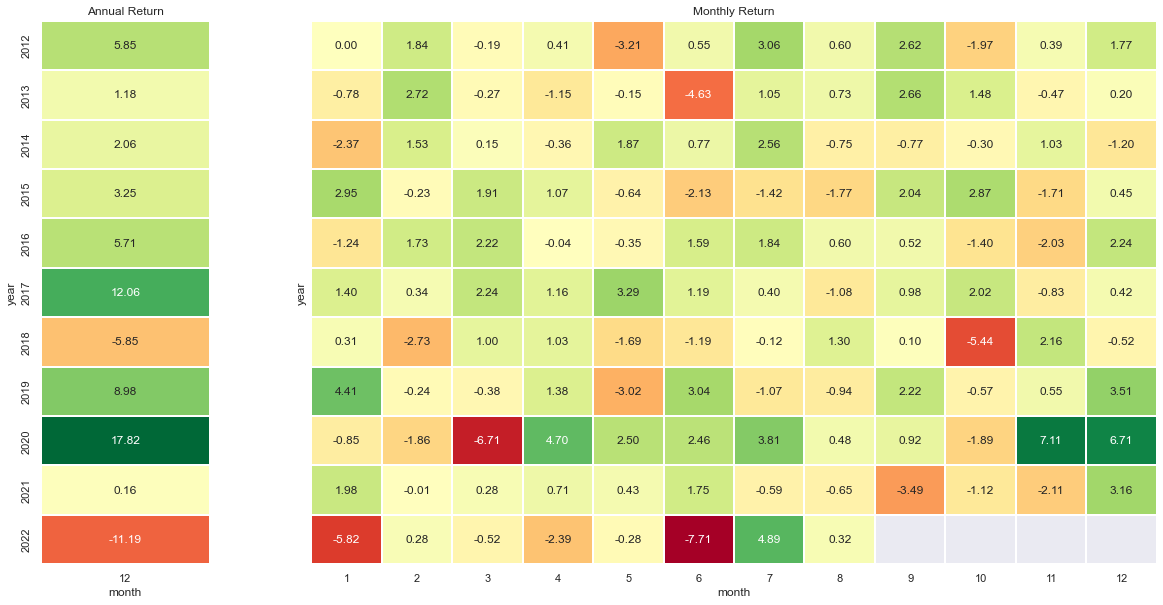

In [21]:
# 수수료 고려 X

_, cumReturnWithoutFee = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weightDf)
_,_,_ = getEvaluation(cumReturnWithoutFee)

### 함수화



In [10]:
def getRebalPortResultWithFee(closeDataSet, totalAsset, period = "month", weightDf=None):
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    else:
        rebalancingDate = weightDf.index # 리밸런싱 날짜
    
    totalAsset = totalAsset # 초기 자본금
    prevQuantity = 0 # 초기 자산 보유량
    
    quantityDf = pd.DataFrame() # 시기별 각 자산 보유량을 담을 데이터프레임
    portfolio = pd.DataFrame() # 전체 자산흐름을 담을 데이터프레임
    
    
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당기 리밸런싱 비율

        capacity = totalAsset * weight # 리밸런싱 비율에 따른 자산별 가용액,

        priceData = closeDataSet.loc[start: end] # 당기 가격 데이터
        priceOnRebalDay = priceData.iloc[0] # 리밸런싱 당일 가격

        quantity = capacity // priceOnRebalDay # 이번달 capacity에 따라 실제 보유 해야 할 주식수
        diffQuantity = quantity - prevQuantity # 실제 매매해야하는 수량, 양수-> 매수, 음수 -> 매도

        fee = abs(diffQuantity) *  priceOnRebalDay * 0.0015 # 수수료, 0.15% => 0.0015
        leftCash = (capacity - quantity * priceOnRebalDay - fee).sum()# 잔여 현금

        assetFlow = quantity * priceData # 수량*가격 = 각 자산 흐름   
        valueOnLastDay = assetFlow.iloc[-1].sum() # 월말 평가액

        assetFlow['leftCash'] = round(leftCash, 2)
        portfolio = pd.concat([portfolio, assetFlow]) # 자산 흐름 데이터프레임에 추가
#         quantityDf = quantityDf.append([quantity]) # 자산 보유량 데이터프레임에 추가

        # 슬리피지를 고려하고 싶다면 여기에 적당한 패널티를 부여할 것
        totalAsset = (valueOnLastDay + leftCash) - fee # (월말 평가액 + 잔여 현금 - 수수료) totalAsset 업데이트,,
        prevQuantity = quantity # 이전 자산 보유량 업데이트
        
        start = end # 리밸런싱 날짜 업데이트
        
    # quantityDf 인덱스 설정
#     quantityDf.index = rebalancingDate[:-1]
    # 매달 마지막 영업일엔 리밸런싱이 들어간 row만 남긴다.
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')]
    # 포트폴리오 자산흐름
    portfolioAssetFlow = portfolio.sum(axis=1)
    # 누적 수익률
    cumReturn = portfolioAssetFlow / portfolioAssetFlow.iloc[0]
    # 일간 수익률
    dayReturn = (cumReturn / cumReturn.shift(1)).fillna(1)
    
    return dayReturn, cumReturn

In [11]:
getRebalPortResultWithFee(closeDataSet=closeDataSet, totalAsset=1000000)

(Date
 2012-01-31    1.000000
 2012-02-01    1.001045
 2012-02-02    1.004942
 2012-02-03    0.997637
 2012-02-06    1.000074
                 ...   
 2022-08-03    1.002048
 2022-08-04    1.002144
 2022-08-05    1.003984
 2022-08-08    0.997272
 2022-08-09    0.998973
 Length: 2593, dtype: float64,
 Date
 2012-01-31    1.000000
 2012-02-01    1.001045
 2012-02-02    1.005992
 2012-02-03    1.003615
 2012-02-06    1.003689
                 ...   
 2022-08-03    1.408482
 2022-08-04    1.411501
 2022-08-05    1.417124
 2022-08-08    1.413259
 2022-08-09    1.411806
 Length: 2593, dtype: float64)